## Reference:https://blog.csdn.net/weixin_43718786/article/details/116901737

In [1]:
# ! pip install datasets transformers rouge-score nltk
! pip install datasets transformers

In [2]:
# ! pip install rouge_score

In [3]:
from datasets import load_dataset, load_metric

raw_datasets = load_dataset("yash1811/news_summaries")
metric = load_metric("rouge")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-3-25e947eb2507>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content a

In [4]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'article', 'date', 'time', 'source', 'author', 'abstract'],
        num_rows: 68791
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'article', 'date', 'time', 'source', 'author', 'abstract'],
        num_rows: 8599
    })
    test: Dataset({
        features: ['Unnamed: 0', 'article', 'date', 'time', 'source', 'author', 'abstract'],
        num_rows: 8599
    })
})

In [5]:
from datasets import Dataset

# 如果 raw_datasets 是你的資料集
raw_datasets = raw_datasets.remove_columns(['Unnamed: 0', 'date', 'time', 'source', 'author'])


In [6]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract'],
        num_rows: 68791
    })
    validation: Dataset({
        features: ['article', 'abstract'],
        num_rows: 8599
    })
    test: Dataset({
        features: ['article', 'abstract'],
        num_rows: 8599
    })
})

In [7]:
# 定義一個函數來新增 'id' 到每個資料集中
def add_id(example, idx):
    example['id'] = idx
    return example

# 在每個資料集中添加 'id' 變數
for split in ['train', 'validation', 'test']:
    raw_datasets[split] = raw_datasets[split].map(add_id, with_indices=True)

# 查看更新後的 DatasetDict
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract', 'id'],
        num_rows: 68791
    })
    validation: Dataset({
        features: ['article', 'abstract', 'id'],
        num_rows: 8599
    })
    test: Dataset({
        features: ['article', 'abstract', 'id'],
        num_rows: 8599
    })
})


In [8]:
fake_preds = ["hello there", "general kenobi"]
fake_labels = ["hello there", "general kenobi"]
metric.compute(predictions=fake_preds, references=fake_labels)


{'rouge1': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rouge2': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeL': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeLsum': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0))}

In [9]:
model_checkpoint = "facebook/bart-large-cnn"

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = "" # BART-12-3


In [12]:
max_input_length = 1024 # input, source text
max_target_length = 128 # summary, target text

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["abstract"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [13]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)


Map:   0%|          | 0/8599 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [14]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 68791
    })
    validation: Dataset({
        features: ['article', 'abstract', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8599
    })
    test: Dataset({
        features: ['article', 'abstract', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8599
    })
})

In [15]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
! pip install fire

In [17]:

import warnings
from pathlib import Path
from typing import List, Tuple, Union

import fire
from torch import nn

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, PreTrainedModel
from transformers.utils import logging

logger = logging.get_logger(__name__)


In [18]:
def copy_layers(src_layers: nn.ModuleList, dest_layers: nn.ModuleList, layers_to_copy: List[int]) -> None:
    layers_to_copy = nn.ModuleList([src_layers[i] for i in layers_to_copy])
    assert len(dest_layers) == len(layers_to_copy), f"{len(dest_layers)} != {len(layers_to_copy)}"
    dest_layers.load_state_dict(layers_to_copy.state_dict())


LAYERS_TO_COPY = {
    # maps  num layers in teacher -> num_layers in student -> which teacher layers to copy.
    # 12: bart, 16: pegasus, 6: marian/Helsinki-NLP
    12: {
        1: [0],  # This says that if the teacher has 12 layers and the student has 1, copy layer 0 of the teacher
        2: [0, 6],
        3: [0, 6, 11],      # the first, 7th and 12th decode layers
        4: [0, 4, 8, 11],
        6: [0, 2, 4, 7, 9, 11],
        9: [0, 1, 2, 4, 5, 7, 9, 10, 11],
        12: list(range(12)),
    },
    16: {  # maps  num layers in student -> which teacher layers to copy
        1: [0],
        2: [0, 15],
        3: [0, 8, 15],
        4: [0, 5, 10, 15],
        6: [0, 3, 6, 9, 12, 15],
        8: [0, 2, 4, 6, 8, 10, 12, 15],
        9: [0, 1, 3, 5, 7, 9, 11, 13, 15],
        12: [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 15],
        16: list(range(16)),
    },
    6: {1: [0], 2: [0, 5], 3: [0, 2, 5], 4: [0, 1, 3, 5], 6: list(range(6))},
}
LAYERS_TO_SUPERVISE = {
    # maps  num layers in student -> which teacher layers to copy.
    6: {1: [5], 2: [3, 5], 3: [1, 4, 5], 4: [1, 2, 4, 5]},
    12: {1: [11], 2: [5, 11], 3: [3, 7, 11], 6: [1, 3, 5, 8, 10, 11]},
    16: {1: [15], 4: [4, 9, 12, 15], 8: [1, 3, 5, 7, 9, 11, 13, 15]},
}


In [19]:

def create_student_by_copying_alternating_layers(
    teacher: Union[str, PreTrainedModel],
    save_path: Union[str, Path] = "student",
    e: Union[int, None] = None,
    d: Union[int, None] = None,
    copy_first_teacher_layers=False,
    e_layers_to_copy=None,
    d_layers_to_copy=None,
    **extra_config_kwargs
) -> Tuple[PreTrainedModel, List[int], List[int]]:

    _msg = "encoder_layers and decoder_layers cannot be both None-- you would just have an identical teacher."
    assert (e is not None) or (d is not None), _msg
    if isinstance(teacher, str):
        AutoTokenizer.from_pretrained(teacher).save_pretrained(save_path)  # purely for convenience
        teacher = AutoModelForSeq2SeqLM.from_pretrained(teacher).eval()
    else:

        assert isinstance(teacher, PreTrainedModel), f"teacher must be a model or string got type {type(teacher)}"
    init_kwargs = teacher.config.to_diff_dict()

    try:
        teacher_e, teacher_d = teacher.config.encoder_layers, teacher.config.decoder_layers
        if e is None:
            e = teacher_e
        if d is None:
            d = teacher_d
        init_kwargs.update({"encoder_layers": e, "decoder_layers": d})
    except AttributeError:  # T5
        teacher_e, teacher_d = teacher.config.num_layers, teacher.config.num_decoder_layers
        if e is None:
            e = teacher_e
        if d is None:
            d = teacher_d
        init_kwargs.update({"num_layers": e, "num_decoder_layers": d})

    # Kwargs to instantiate student: teacher kwargs with updated layer numbers + **extra_config_kwargs
    init_kwargs.update(extra_config_kwargs)

    # Copy weights
    student_cfg = teacher.config_class(**init_kwargs)
    student = AutoModelForSeq2SeqLM.from_config(student_cfg)
    # Start by copying the full teacher state dict this will copy the first N teacher layers to the student.
    info = student.load_state_dict(teacher.state_dict(), strict=False)
    assert info.missing_keys == [], info.missing_keys  # every student key should have a teacher keys.

    if copy_first_teacher_layers:  # Our copying is done. We just log and save
        e_layers_to_copy, d_layers_to_copy = list(range(e)), list(range(d))
        logger.info(
            f"Copied encoder layers {e_layers_to_copy} and decoder layers {d_layers_to_copy}. Saving them to {save_path}"
        )
        student.save_pretrained(save_path)
        return student, e_layers_to_copy, d_layers_to_copy

    # Decide which layers of the teacher to copy. Not exactly alternating -- we try to keep first and last layer.
    if e_layers_to_copy is None:
        e_layers_to_copy: List[int] = pick_layers_to_copy(e, teacher_e)
    if d_layers_to_copy is None:
        d_layers_to_copy: List[int] = pick_layers_to_copy(d, teacher_d)

    try:
        copy_layers(teacher.model.encoder.layers, student.model.encoder.layers, e_layers_to_copy)
        copy_layers(teacher.model.decoder.layers, student.model.decoder.layers, d_layers_to_copy)
    except AttributeError:  # For t5, student.model.encoder.layers is called student.encoder.block
        copy_layers(teacher.encoder.block, student.encoder.block, e_layers_to_copy)
        copy_layers(teacher.decoder.block, student.decoder.block, d_layers_to_copy)
    logger.info(
        f"Copied encoder layers {e_layers_to_copy} and decoder layers {d_layers_to_copy}. Saving them to {save_path}"
    )
    student.config.init_metadata = dict(
        teacher_type=teacher.config.model_type,
        copied_encoder_layers=e_layers_to_copy,
        copied_decoder_layers=d_layers_to_copy,
    )
    student.save_pretrained(save_path)
    # Save information about copying for easier reproducibility

    return student, e_layers_to_copy, d_layers_to_copy


In [20]:
def pick_layers_to_copy(n_student, n_teacher):
    try:
        val = LAYERS_TO_COPY[n_teacher][n_student]
        return val
    except KeyError:
        if n_student != n_teacher:
            warnings.warn(
                f"no hardcoded layers to copy for teacher {n_teacher} -> student {n_student}, defaulting to first {n_student}"
            )
        return list(range(n_student))


In [21]:
model, list_en, list_de = create_student_by_copying_alternating_layers(model, './drive/My Drive/tran.pth', 12, 3)


In [22]:
! pip install accelerate>=0.20.1
# ! pip install transformers[torch]

In [23]:
batch_size = 8
args = Seq2SeqTrainingArguments(
    output_dir="results",
    num_train_epochs=2,  # demo
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=batch_size,  # demo
    per_device_eval_batch_size=batch_size,
    # learning_rate=3e-05,
    learning_rate=1e-4,
    warmup_steps=500,
    weight_decay=0.1,
    label_smoothing_factor=0.1,
    predict_with_generate=True,
    logging_dir="logs",
    logging_steps=50,
    save_total_limit=3,
)


In [24]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [25]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}


In [26]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 68791
    })
    validation: Dataset({
        features: ['article', 'abstract', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8599
    })
    test: Dataset({
        features: ['article', 'abstract', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8599
    })
})

In [27]:
tokenized_datasets["train"].select(range(5000))

Dataset({
    features: ['article', 'abstract', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 5000
})

In [28]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"].select(range(5000)),
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [29]:
trainer.train()


You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
50,9.042900
100,4.586400
150,3.972800
200,3.817400
250,3.606600
300,3.474600
350,3.459800
400,3.377400
450,3.369300
500,3.280900


TrainOutput(global_step=1250, training_loss=3.298835534667969, metrics={'train_runtime': 526.2957, 'train_samples_per_second': 19.001, 'train_steps_per_second': 2.375, 'total_flos': 1130785511424000.0, 'train_loss': 3.298835534667969, 'epoch': 2.0})

In [30]:
trainer.state.log_history[0]['loss']

9.0429

In [31]:
len(trainer.state.log_history)

26

In [32]:
loss_total=[]
for i in range(len(trainer.state.log_history)-1):
  # print(i)
  loss_total.append(trainer.state.log_history[i]['loss'])

print(loss_total,len(loss_total))

[9.0429, 4.5864, 3.9728, 3.8174, 3.6066, 3.4746, 3.4598, 3.3774, 3.3693, 3.2809, 3.3047, 3.1976, 2.9502, 2.719, 2.6662, 2.6748, 2.5722, 2.6373, 2.6221, 2.5613, 2.5795, 2.5438, 2.497, 2.5211, 2.4358] 25


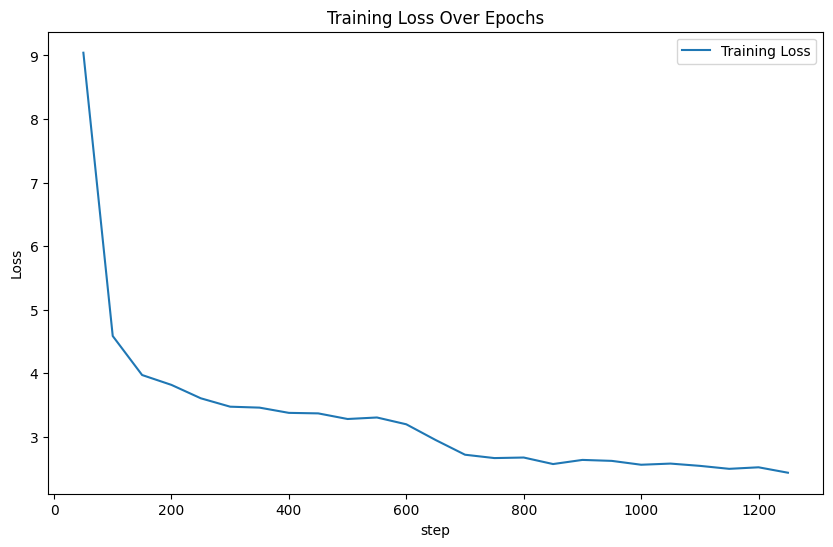

In [33]:
import matplotlib.pyplot as plt

# 取得訓練過程中的損失
# train_losses = trainer.state.log_history["train_loss"]
x=range(50, 1300, 50)
y=loss_total
# 繪製折線圖
plt.figure(figsize=(10, 6))
# plt.plot(train_losses, label="Training Loss")
plt.plot(x,y,label="Training Loss")
plt.xlabel("step")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [34]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [35]:
# 用訓練好的模型生成測試資料集的預測結果
predictions = trainer.predict(tokenized_datasets["test"])

# 取得預測結果
predicted_ids = predictions.predictions

# 將預測的索引轉換為文字
predicted_texts = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)


In [44]:
tokenized_datasets["test"]['abstract']

['AAP moves Supreme Court over delay in Delhi MCD mayor polls',
 'No free travel to gallantry winners in Rajdhani, Shatabdi: Railway',
 "Mumbai court orders husband to pay ₹1 lakh to wife for hiding he's gay",
 "Train operator prevents woman's suicide bid on Navi Mumbai railway track",
 "Congress suffers from limitless lack of knowledge: T'gana CM KCR",
 'PM Modi inaugurates India Energy Week 2023 in Bengaluru',
 'Police spend 3 nights at a Mumbai station to arrest serial bag lifter',
 'Rod falls from 8th floor, pierces through 26-year-old man in Thane',
 '1 arrested in Jharkhand for running over pregnant woman with tractor',
 'RSS invites woman chief guest at its event for the 1st time in history',
 " Rachakonda Police chief takes part in 'Pureathon'; pics surface",
 "Not a river but my building's basement: Twitter user on video of flooding after B'luru rain",
 'Man sitting inside car dies as gas cylinder fitted in vehicle explodes in TN',
 "After 50% rebate offer, ₹13.8 cr traffic fi

In [36]:
predicted_texts

["AAP's mayoral candidate Shelly Oberoi moves SC to SC demanding time-bound mayoral polls: Delhi mayor polls    Report ?  rolleyrolley  Report  msmsmsnnn  Report Report Report  report report  ",
 'Railways turns down proposal to allow complimentary travel in Rajdhani, Shatabdi trains for PPMG awardees, widows, PMG awardee  ??  Report   Report Report Report  Report report  Report  msms',
 'Mumbai man ordered to pay ₹15,000 monthly for hiding gay man for hiding his he was gay, asks him for hiding him him him  ?   Report Report Report  rolleyrolleyrolley in marriage  vezvezvez  ',
 'On-duty operator saves 18-yr-old on-duty woman on track in Navi Mumbai, video surfaces   rolleyrolleyrolley   Report Report  Report  vezvezvez  ritritriti Mumbai; pic surfaces rolley ',
 "Congress suffers from limitless lack of knowledge: T'gana CM KCR on Cong's remarks on Congress   rolleyrolley   Report Report Report   pic pic pic surfaces  vezvezveziiiIIIii ? ",
 "IEW 2023 to be held in B'luru from Feb 6-8,

In [46]:
metric.compute(predictions=predicted_texts, references=tokenized_datasets["test"]['abstract'])

{'rouge1': AggregateScore(low=Score(precision=0.27237186974961847, recall=0.6743635270761159, fmeasure=0.3854872128271585), mid=Score(precision=0.27414938041096504, recall=0.6784038222072373, fmeasure=0.3878898611747794), high=Score(precision=0.2760058601048366, recall=0.6827343450674667, fmeasure=0.39035200347552157)),
 'rouge2': AggregateScore(low=Score(precision=0.15567488650818556, recall=0.4064614512485016, fmeasure=0.22346913837531365), mid=Score(precision=0.1577213798987903, recall=0.41161633557680677, fmeasure=0.2263591633642647), high=Score(precision=0.1596241897144968, recall=0.41662064953644024, fmeasure=0.2289764409910034)),
 'rougeL': AggregateScore(low=Score(precision=0.2411971909940619, recall=0.5978854484183508, fmeasure=0.34152665970649915), mid=Score(precision=0.24305825273392132, recall=0.6020990902787609, fmeasure=0.34399356402471115), high=Score(precision=0.24502569531691878, recall=0.6064860630018548, fmeasure=0.34664898364176516)),
 'rougeLsum': AggregateScore(lo

In [45]:
metric.compute(predictions=predicted_texts[:1000], references=tokenized_datasets["test"]['abstract'][:1000])

{'rouge1': AggregateScore(low=Score(precision=0.27279168930014636, recall=0.6709663136123202, fmeasure=0.38526451067631), mid=Score(precision=0.2785134147041951, recall=0.6831319398652611, fmeasure=0.3929643688211391), high=Score(precision=0.2841468451359337, recall=0.6947310140862103, fmeasure=0.40031603745804695)),
 'rouge2': AggregateScore(low=Score(precision=0.15410664233177318, recall=0.3986915863813476, fmeasure=0.22085666572755874), mid=Score(precision=0.16029147269374316, recall=0.4130689045431698, fmeasure=0.22922603697631305), high=Score(precision=0.16644192315179926, recall=0.4286103664105506, fmeasure=0.23783475900455525)),
 'rougeL': AggregateScore(low=Score(precision=0.24228761052854275, recall=0.5965473186686046, fmeasure=0.3422912706697897), mid=Score(precision=0.24819171234427992, recall=0.6086989015735735, fmeasure=0.350155520610669), high=Score(precision=0.25373453984419253, recall=0.6205091542795653, fmeasure=0.3573964241877546)),
 'rougeLsum': AggregateScore(low=Sc

In [37]:
# from rouge_score import rouge_scorer
# import pandas as pd

# # Assuming prediction_text is a Pandas DataFrame
# prediction_text=pd.DataFrame()
# prediction_text["Generated Text"] = predicted_texts
# prediction_text["Generated Text"]=prediction_text["Generated Text"].astype(str).apply(lambda x: x.lower())
# # prediction_text["Actual Text"] = prediction_text["Actual Text"].astype(str).apply(lambda x: x.lower())

# # Initialize Rouge scorer
# scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

# # Calculate Rouge scores for each row
# scores_list = []
# for index, row in prediction_text.iterrows():
#     scores = scorer.score(row["Generated Text"], row["Actual Text"])
#     scores_list.append(scores)

# scores_df = pd.DataFrame(scores_list)

# # Extract and print the F-measure
# f_measure_rouge1 = scores_df['rouge1'].apply(lambda x: x.fmeasure)
# precision_rouge1 = scores_df['rouge1'].apply(lambda x: x.precision)
# print("F-measure for Rouge1:", f_measure_rouge1.mean())
# print("Precision for Rouge1:", precision_rouge1.mean())

In [38]:
# from sklearn.metrics import f1_score

# # 真實標籤
# true_labels = tokenized_datasets["test"]["abstract"]

# # 假設 `true_labels` 是多類別的標籤，`predicted_texts` 是模型的預測
# # 請確保兩者的形狀和類型相匹配

# # 計算F1 Score
# f1 = f1_score(true_labels, predicted_texts, average='micro')  # 使用micro平均，也可以選擇其他平均方式
# print("F1 Score:", f1)